# Coursework

## Question 1

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist #to import our dataset
from tensorflow.keras.models import Sequential, Model # imports our type of network
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout # imports our layers we want to use

from tensorflow.python.keras.losses import categorical_crossentropy #loss function
from tensorflow.keras.optimizers import Adam #optimisers
from tensorflow.keras.utils import to_categorical #some function for data preparation

In [2]:
batch_size = 128
num_classes = 19
epochs = 20

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [3]:
images = np.concatenate((x_train, x_test), axis=0)
labels = np.concatenate((y_train, y_test), axis=0)

np.random.seed(73289)

In [4]:
def create_combined_dataset(iamges, labels, dataset_size=10000):
    combined_images = []
    combined_labels = []
    
    for _ in range(dataset_size):
        idx1, idx2 = np.random.choice(np.arange(len(images)), 2, replace=True)
        img1, img2 = images[idx1], images[idx2]
        label1, label2 = labels[idx1], labels[idx2]
        
        combined_image = np.hstack((img1, img2))
        combined_label = label1 + label2
        
        combined_images.append(combined_image)
        combined_labels.append(combined_label)
        
    combined_images = np.array(combined_images).reshape(-1, 28, 56, 1)
    combined_labels = np.array(combined_labels)
    
    return combined_images, combined_labels

In [53]:
dataset_size = 100000
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

print("Train size: ", train_size)
print("Validation size: ", val_size)
print("Test size: ", test_size)

Train size:  60000
Validation size:  20000
Test size:  20000


In [54]:
combined_images, combined_labels = create_combined_dataset(images, labels, dataset_size)

(28, 56, 1)
14


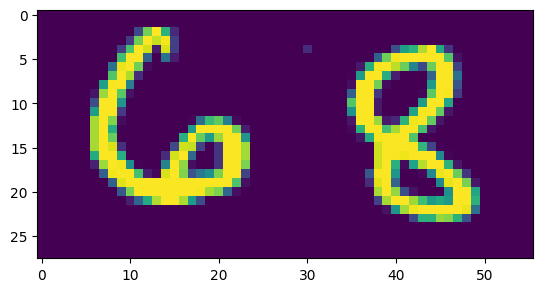

In [55]:
print(combined_images[0].shape)
print(combined_labels[0])
plt.imshow(combined_images[0])

In [56]:
# Split dataset
train_images, train_labels = combined_images[:train_size], combined_labels[:train_size]
val_images, val_labels = combined_images[train_size:train_size+val_size], combined_labels[train_size:train_size+val_size]
test_images, test_labels = combined_images[train_size+val_size:], combined_labels[train_size+val_size:]

In [57]:
train_labels = to_categorical(train_labels, num_classes)
val_labels = to_categorical(val_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

In [58]:
print("Train images shape: ", train_images.shape)
print("Validation images shape: ", val_images.shape)
print("Test images shape: ", test_images.shape)

Train images shape:  (60000, 28, 56, 1)
Validation images shape:  (20000, 28, 56, 1)
Test images shape:  (20000, 28, 56, 1)


## Question 2

In [1]:
model = Sequential([
    Input(shape=(28, 56, 1)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])

NameError: name 'Sequential' is not defined

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['accuracy'])

In [ ]:
model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=20,
    batch_size=128)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3133 - loss: 0.0416 - val_accuracy: 0.7246 - val_loss: 0.0204
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7441 - loss: 0.0192 - val_accuracy: 0.8123 - val_loss: 0.0143
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8222 - loss: 0.0139 - val_accuracy: 0.8454 - val_loss: 0.0119
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8566 - loss: 0.0113 - val_accuracy: 0.8602 - val_loss: 0.0108
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8776 - loss: 0.0097 - val_accuracy: 0.8796 - val_loss: 0.0095
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8931 - loss: 0.0085 - val_accuracy: 0.8849 - val_loss: 0.0089
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9022 - loss: 0.0079 - val_accuracy: 0.8932 - val_loss: 0.0085
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9133 - loss: 0.0070 - val_accuracy: 0.

In [ ]:
test_loss, test_mae = model.evaluate(test_images, test_labels)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9242 - loss: 0.0062


In [ ]:
import optuna

In [ ]:
def objective(trial):
    # Suggest values for hyperparameters
    num_units_layer1 = trial.suggest_int("units_layer1", 256, 512, step=32)
    num_units_layer2 = trial.suggest_int("units_layer2", 256, 512, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [128, 256, 512])

    # Build the model
    model = Sequential([
        Input(shape=(28, 56, 1)),
        Flatten(),
        Dense(num_units_layer1, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_units_layer2, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train the model
    history = model.fit(
        train_images, train_labels,
        validation_data=(val_images, val_labels),
        epochs=10,  # Use a small number of epochs for tuning
        batch_size=batch_size,
        verbose=0  # Suppress output for faster tuning
    )
    
    # Evaluate the model on validation data
    val_accuracy = history.history['val_accuracy'][-1]  # Last epoch's validation accuracy
    return -val_accuracy


In [ ]:
# Create a study and optimize the objective function
storage = "sqlite:///study.db"
study = optuna.create_study(direction="minimize", storage=storage, load_if_exists=True)
study.optimize(objective, n_trials=5)  # Run 50 trials

best_params = study.best_params
best_accuracy = -study.best_value  # Negate the value to get accuracy
print(f"Best parameters: {best_params}")
print(f"Best validation accuracy: {best_accuracy:.4f}")

[I 2024-12-01 20:51:58,111] A new study created in RDB with name: no-name-0de52a26-0012-4b3e-846e-b5e7a5c22566
[I 2024-12-01 20:52:08,906] Trial 0 finished with value: -0.900600016117096 and parameters: {'units_layer1': 448, 'units_layer2': 416, 'dropout_rate': 0.5, 'learning_rate': 0.0016921901858626518, 'batch_size': 512}. Best is trial 0 with value: -0.900600016117096.
[I 2024-12-01 20:52:34,563] Trial 1 finished with value: -0.9230499863624573 and parameters: {'units_layer1': 384, 'units_layer2': 416, 'dropout_rate': 0.2, 'learning_rate': 0.0014159231001785442, 'batch_size': 128}. Best is trial 1 with value: -0.9230499863624573.
[I 2024-12-01 20:52:46,179] Trial 2 finished with value: -0.4345499873161316 and parameters: {'units_layer1': 384, 'units_layer2': 512, 'dropout_rate': 0.2, 'learning_rate': 0.009597445226498219, 'batch_size': 512}. Best is trial 1 with value: -0.9230499863624573.
[I 2024-12-01 20:53:10,662] Trial 3 finished with value: -0.826200008392334 and parameters: {'

Best parameters: {'units_layer1': 384, 'units_layer2': 416, 'dropout_rate': 0.2, 'learning_rate': 0.0014159231001785442, 'batch_size': 128}
Best validation accuracy: 0.9230


In [ ]:
# Build the best model with the optimized parameters
best_model = Sequential([
    Flatten(input_shape=(28, 56, 1)),
    Dense(best_params['units_layer1'], activation='relu'),
    Dropout(best_params['dropout_rate']),
    Dense(best_params['units_layer2'], activation='relu'),
    Dense(num_classes, activation='softmax')
])

best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the best model on the full training set
best_model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=20,
    batch_size=best_params['batch_size']
)

best_model.evaluate(test_images, test_labels)

Epoch 1/20


C:\Users\JZ\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2987 - loss: 2.1138 - val_accuracy: 0.7412 - val_loss: 0.8504
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7101 - loss: 0.9217 - val_accuracy: 0.8142 - val_loss: 0.6098
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7957 - loss: 0.6629 - val_accuracy: 0.8582 - val_loss: 0.4803
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8389 - loss: 0.5249 - val_accuracy: 0.8708 - val_loss: 0.4294
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8609 - loss: 0.4507 - val_accuracy: 0.8878 - val_loss: 0.3736
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8820 - loss: 0.3868 - val_accuracy: 0.8995 - val_loss: 0.3380
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8927 - loss: 0.3459 - val_accuracy: 0.9032 - val_loss: 0.3291
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9040 - loss: 0.3119 - val_accuracy: 0.9123 - 

[0.28177395462989807, 0.930400013923645]

## Question 3

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [59]:
# Flatten the images
train_images_flat = train_images.reshape(train_images.shape[0], -1)
test_images_flat = test_images.reshape(test_images.shape[0], -1)

In [60]:
train_images_flat.shape, test_images_flat.shape

((60000, 1568), (20000, 1568))

In [61]:
# Random Forest Classifier

RndFrstClass = RandomForestClassifier(n_estimators=750, max_depth=40, random_state=0, min_samples_split=2, 
                                      min_samples_leaf=1, max_features=5, oob_score=True)
RndFrstClass.fit(train_images_flat, train_labels) 
RndFrstPred = RndFrstClass.predict(test_images_flat)

RFC_model_accuracy = RndFrstClass.score(test_images_flat, test_labels)
print(f"Accuracy of Random Forest Classifier: {RFC_model_accuracy}")

Accuracy: 0.0476


In [ ]:
# Random Forest Classifier
train_labels_flat = np.argmax(train_labels, axis=1)
test_labels_flat = np.argmax(test_labels, axis=1)

svcClass = SVC(gamma='auto')
svcClass.fit(train_images_flat, train_labels_flat) 
svcPred = svcClass.predict(test_images_flat)

SVC_model_accuracy = svcClass.score(test_images_flat, test_labels_flat)
print(f"Accuracy of Support Vector Classifier: {SVC_model_accuracy}")